In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# MNIST dataset Loaded
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Filtering classes 0, 1, and 2
train_mask = np.isin(y_train, [0, 1, 2])
test_mask = np.isin(y_test, [0, 1, 2])

X_train_012 = X_train[train_mask]
y_train_012 = y_train[train_mask]
X_test_012 = X_test[test_mask]
y_test_012 = y_test[test_mask]

# images for PCA flattened
X_train_012_flat = X_train_012.reshape(X_train_012.shape[0], -1)

# mean of the data
mean = np.mean(X_train_012_flat, axis=0)

# data centered
centered_data = X_train_012_flat - mean

# covariance matrix
cov_matrix = np.cov(centered_data.T)

# eigen decomposition
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# eigenvalues and corresponding eigenvectors sort
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

# top p eigenvectors corresponding to top p eigenvalues
p = 10
selected_eigenvectors = sorted_eigenvectors[:, :p]

# Projected data onto selected eigenvectors
projected_data = np.dot(centered_data, selected_eigenvectors)


11490434/11490434 [==============================] - 0s 0us/step


/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


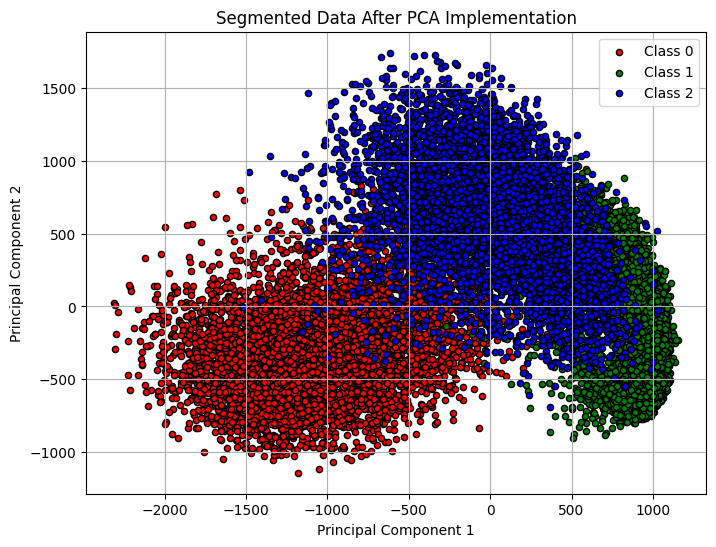

In [3]:
# Plot Segmented Data After PCA Implementation
plt.figure(figsize=(8, 6))
colors = ['r', 'g', 'b']  # Define colors for each class

# Plot each class separately
for i, label in enumerate([0, 1, 2]):
    # Select data points belonging to the current class
    class_data = projected_data[y_train_012 == label]
    # Scatter plot the data points for the current class
    plt.scatter(class_data[:, 0], class_data[:, 1], c=colors[i], label=f'Class {label}' , s=20,  edgecolors='k')

plt.title('Segmented Data After PCA Implementation')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

# decision tree
def gini_index(labels):
    classes, counts = np.unique(labels, return_counts=True)
    probabilities = counts / len(labels)
    gini = 1 - np.sum(probabilities ** 2)
    return gini

def find_best_split(data, labels):
    best_gini = float('inf')
    best_dimension = -1
    best_threshold = None

    for dimension in range(data.shape[1]):
        unique_values = np.unique(data[:, dimension])
        for value in unique_values:
            # masks for splitting the data based on the current dimension and threshold
            left_mask = data[:, dimension] <= value
            right_mask = ~left_mask

            left_gini = gini_index(labels[left_mask])
            right_gini = gini_index(labels[right_mask])
            # total Gini index for current split
            total_gini = (left_gini * np.sum(left_mask) + right_gini * np.sum(right_mask)) / len(labels)

            # Updating the best split if: current split has a lower Gini index
            if total_gini < best_gini:
                best_gini = total_gini
                best_dimension = dimension
                best_threshold = value
        print("dimentions", dimension)
    return best_dimension, best_threshold


def grow_decision_tree(data, labels, max_leaf_nodes):
    if max_leaf_nodes == 1 or len(np.unique(labels)) == 1:
        return {'leaf': True, 'class': np.argmax(np.bincount(labels))}

    # best split for the current data and labels
    dimension, threshold = find_best_split(data, labels)

    # masks for the left and right subsets based on the split
    left_mask = data[:, dimension] <= threshold
    right_mask = ~left_mask

    # If one of the subsets is empty, createed a leaf node
    if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
        return {'leaf': True, 'class': np.argmax(np.bincount(labels))}

    # Recursively grown the left and right subtrees
    left_subtree = grow_decision_tree(data[left_mask], labels[left_mask], max_leaf_nodes - 1)
    right_subtree = grow_decision_tree(data[right_mask], labels[right_mask], max_leaf_nodes - 1)

    # decision tree node with the split information and subtrees constructed
    return {'leaf': False, 'dimension': dimension, 'threshold': threshold,
            'left_subtree': left_subtree, 'right_subtree': right_subtree}

decision_tree = grow_decision_tree(projected_data, y_train_012, max_leaf_nodes=3)

# test samples using decision tree
def classify_sample(sample, tree):
    # current node: leaf node condition check return predicted class label
    if tree['leaf']:
        return tree['class']
    else:
        split_dimension = tree['dimension']
        split_threshold = tree['threshold']

        # Checked: sample falls into which subtree(left or right) based on the split then classified the sample
        if sample[split_dimension] <= split_threshold:
            return classify_sample(sample, tree['left_subtree'])
        else:
            return classify_sample(sample, tree['right_subtree'])

X_test_012_flat = X_test_012.reshape(X_test_012.shape[0], -1)
centered_test_data = X_test_012_flat - mean
projected_test_data = np.dot(centered_test_data, selected_eigenvectors)
test_predictions = [classify_sample(sample, decision_tree) for sample in projected_test_data]

# accuracy
def calculate_accuracy(true_labels, predicted_labels):
    # no. of correct predictions count
    correct_predictions = np.sum(true_labels == predicted_labels)

    total_samples = len(true_labels)
    return correct_predictions / total_samples

accuracy = calculate_accuracy(y_test_012, test_predictions)
print("Decision Tree Accuracy:", accuracy)


dimentions 0
dimentions 1
dimentions 2
dimentions 3
dimentions 4
dimentions 5
dimentions 6
dimentions 7
dimentions 8
dimentions 9
dimentions 0
dimentions 1
dimentions 2
dimentions 3
dimentions 4
dimentions 5
dimentions 6
dimentions 7
dimentions 8
dimentions 9
dimentions 0
dimentions 1
dimentions 2
dimentions 3
dimentions 4
dimentions 5
dimentions 6
dimentions 7
dimentions 8
dimentions 9
Decision Tree Accuracy: 0.9097553225293931


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_decision_tree(tree, depth=0, feature_names=None, class_names=None):
    indent = "  " * depth
    if tree['leaf']:
        print(indent + "Predict:", class_names[tree['class']])
    else:
        feature_name = feature_names[tree['dimension']]
        print(indent + "Decision:", feature_name, "<=", tree['threshold'])
        print(indent + "--> True:")
        plot_decision_tree(tree['left_subtree'], depth + 1, feature_names, class_names)
        print(indent + "--> False:")
        plot_decision_tree(tree['right_subtree'], depth + 1, feature_names, class_names)

feature_names = [f"Pixel_{i+1}" for i in range(784)]

class_names = ['Class 0', 'Class 1', 'Class 2']

plot_decision_tree(decision_tree, feature_names=feature_names, class_names=class_names)
# plot_decision_tree_graphviz(decision_tree, feature_names=feature_names, class_names=class_names)


Decision: Pixel_1 <= (624.6639084076756+0j)
--> True:
  Decision: Pixel_2 <= (183.28499294944626+0j)
  --> True:
    Predict: Class 0
  --> False:
    Predict: Class 2
--> False:
  Decision: Pixel_3 <= (217.29346036720216+0j)
  --> True:
    Predict: Class 1
  --> False:
    Predict: Class 2


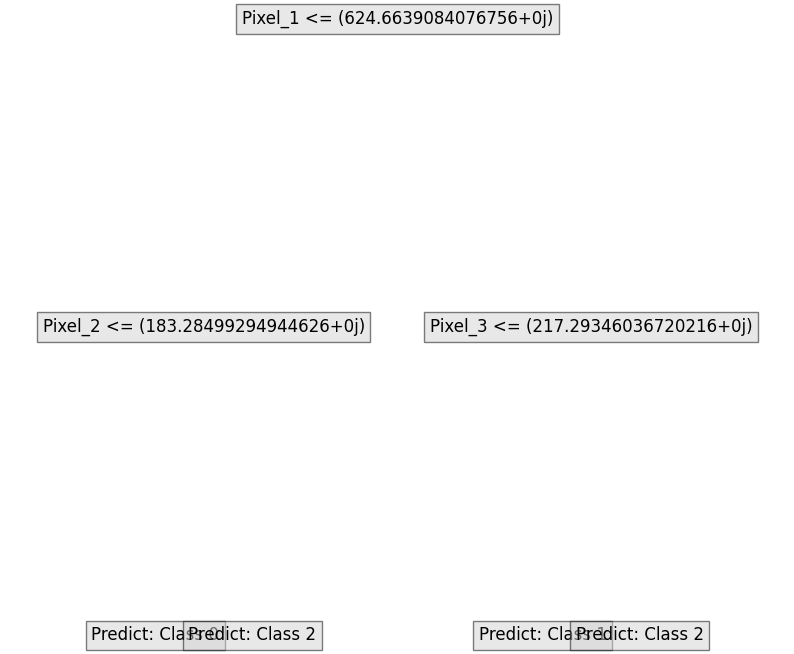

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_decision_tree(tree, depth=0, feature_names=None, class_names=None, x=0.5, y=1, dx=0.5, dy=0.5, ax=None):
    if ax is None:
        ax = plt.gca()

    if tree['leaf']:
        ax.text(x, y, f"Predict: {class_names[tree['class']]}",
                horizontalalignment='center', verticalalignment='center',
                fontsize=12, bbox=dict(facecolor='lightgray', alpha=0.5))
    else:
        feature_name = feature_names[tree['dimension']]
        ax.text(x, y, f"{feature_name} <= {tree['threshold']}",
                horizontalalignment='center', verticalalignment='center',
                fontsize=12, bbox=dict(facecolor='lightgray', alpha=0.5))

        plot_decision_tree(tree['left_subtree'], depth + 1, feature_names, class_names,
                           x - dx / (2 ** (depth + 1)), y - dy, dx / 2, dy, ax)
        plot_decision_tree(tree['right_subtree'], depth + 1, feature_names, class_names,
                           x + dx / (2 ** (depth + 1)), y - dy, dx / 2, dy, ax)

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')

feature_names = [f"Pixel_{i+1}" for i in range(784)]
class_names = ['Class 0', 'Class 1', 'Class 2']

plt.figure(figsize=(10, 8))
plot_decision_tree(decision_tree, feature_names=feature_names, class_names=class_names)
plt.show()


In [ ]:

# class-wise accuracy
def calculate_classwise_accuracy(true_labels, predicted_labels):
    class_wise_accuracy = {}
    unique_labels = np.unique(true_labels)
    i = 0
    while i < len(unique_labels):
      # current class label | mask for samples belonging to the current class
        class_label = unique_labels[i]
        mask = true_labels == class_label

        accuracy = calculate_accuracy(true_labels[mask], predicted_labels[mask])
        class_wise_accuracy[class_label] = accuracy
        i += 1
    return class_wise_accuracy

class_wise_accuracy = calculate_classwise_accuracy(y_test_012, np.array(test_predictions))
print("Decision Tree Class-wise Accuracy:", class_wise_accuracy)


# Bagging
num_datasets = 5
trees = []

for _ in range(num_datasets):
    indices = np.random.choice(len(projected_data), len(projected_data), replace=True)
    sampled_train_data = projected_data[indices]
    sampled_y_train = y_train_012[indices]
    tree = grow_decision_tree(sampled_train_data, sampled_y_train, max_leaf_nodes=3)
    trees.append(tree)

# # Majority voting for test samples
# def bagging_predict(test_samples, trees):
#     predictions = []
#     tree_index = 0
#     for sample in test_samples:
#         sample_predictions = [classify_sample(sample, tree) for tree in trees]
#         predictions.append(max(set(sample_predictions), key=sample_predictions.count))
#     return np.array(predictions)

#     # while tree_index < len(trees):
#     #     sample_index = 0
#     #     sample_predictions = []
#     #     while sample_index < len(test_samples):
#     #         sample_predictions.append(classify_sample(test_samples[sample_index], trees[tree_index]))
#     #         sample_index += 1
#     #     predictions.append(get_majority(sample_predictions))
#     #     tree_index += 1
#     # return np.array(predictions)

# def get_majority(predictions):
#     # majority prediction from a list of predictions
#     return max(set(predictions), key=predictions.count)

# bagging_test_predictions = bagging_predict(projected_test_data, trees)

# # bagging accuracy
# bagging_accuracy = calculate_accuracy(y_test_012, bagging_test_predictions)
# print("Bagging Accuracy:", bagging_accuracy)

# # bagging class-wise accuracy
# bagging_class_wise_accuracy = calculate_classwise_accuracy(y_test_012, bagging_test_predictions)
# print("Bagging Class-wise Accuracy:", bagging_class_wise_accuracy)


Decision Tree Class-wise Accuracy: {0: 0.9285714285714286, 1: 0.9462555066079296, 2: 0.8517441860465116}
dimentions 0
dimentions 1
dimentions 2
dimentions 3
dimentions 4
dimentions 5
dimentions 6
dimentions 7
dimentions 8
dimentions 9
dimentions 0
dimentions 1
dimentions 2
dimentions 3
dimentions 4
dimentions 5
dimentions 6
dimentions 7
dimentions 8
dimentions 9
dimentions 0
dimentions 1
dimentions 2
dimentions 3
dimentions 4
dimentions 5
dimentions 6
dimentions 7
dimentions 8
dimentions 9
dimentions 0
dimentions 1
dimentions 2
dimentions 3
dimentions 4
dimentions 5
dimentions 6
dimentions 7
dimentions 8
dimentions 9
dimentions 0
dimentions 1
dimentions 2
dimentions 3
dimentions 4
dimentions 5
dimentions 6
dimentions 7
dimentions 8
dimentions 9
dimentions 0
dimentions 1
dimentions 2
dimentions 3
dimentions 4
dimentions 5
dimentions 6
dimentions 7
dimentions 8
dimentions 9
dimentions 0
dimentions 1
dimentions 2
dimentions 3
dimentions 4
dimentions 5
dimentions 6
dimentions 7
dimentions 

In [ ]:
# Majority voting for test samples
def bagging_predict(test_samples, trees):
    predictions = []
    tree_index = 0
    for sample in test_samples:
        sample_predictions = [classify_sample(sample, tree) for tree in trees]
        predictions.append(max(set(sample_predictions), key=sample_predictions.count))
    return np.array(predictions)


def get_majority(predictions):
    return max(set(predictions), key=predictions.count)

bagging_test_predictions = bagging_predict(projected_test_data, trees)

# bagging accuracy
bagging_accuracy = calculate_accuracy(y_test_012, bagging_test_predictions)
print("Bagging Accuracy:", bagging_accuracy)

# bagging class-wise accuracy
bagging_class_wise_accuracy = calculate_classwise_accuracy(y_test_012, bagging_test_predictions)
print("Bagging Class-wise Accuracy:", bagging_class_wise_accuracy)


Bagging Accuracy: 0.9151572926596759
Bagging Class-wise Accuracy: {0: 0.9285714285714286, 1: 0.9594713656387666, 2: 0.8536821705426356}
